In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read QDM data

First, we create a read the observation points.

In [2]:
data_dir = pathlib.Path("..") / "data"

In [3]:
bz = np.load(data_dir/'1bin_Bz_muT_20240702.npy')

from skimage.util import random_noise
from skimage.filters import median
from skimage.morphology import disk
# bz = random_noise(bz, mode='s&p', amount=0.1)
bz = median(bz, disk(3))

shape = bz.shape
sensor_sample_distance = 5.0 # sensor height
spacing = 1.0 # spacing in micrometer
x = np.arange(bz.shape[1])*spacing
y = np.arange(bz.shape[0])*spacing
z = np.full(bz.shape, sensor_sample_distance)

In [4]:
data = vd.make_xarray_grid((x,y,z), bz*1.0e3, data_names=['bz'], dims=('y', 'x'), extra_coords_names='z')
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.z.attrs = {"long_name": "sensor sample distance", "units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

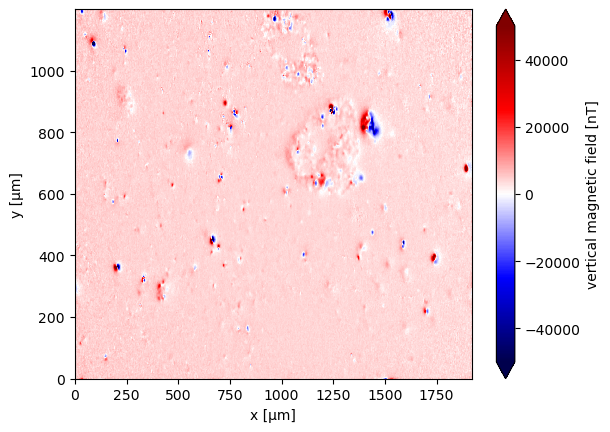

In [5]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [6]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

# x_, y_ = np.meshgrid(data.x.values, data.y.values)
# coordinates = ([x_, y_ , data.z.values])

# Regional Separation

In [7]:
# # regional = vd.Trend(degree=1).fit(coordinates, data.bz.values)
# # data = data.assign(
# #     regional_predicted=regional.predict((data.x, data.y)),
# # )
# # data.bz.values -= data.regional_predicted.values
# # data


# data_table = vd.grid_to_table(data)

# regional = vd.Trend(degree=3).fit((data_table.x, data_table.y), data.bz.values.ravel())

# shape = data.bz.shape
# regional_predicted=regional.predict((data_table.x, data_table.y))
# regional_predicted = np.reshape(regional_predicted, shape)


# data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
# data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# # data.bz.values -= data.regional_predicted.values

# data

In [8]:
# data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [9]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 37MB
Dimensions:  (y: 1200, x: 1920)
Coordinates:
  * x        (x) float64 15kB 0.0 1.0 2.0 3.0 ... 1.917e+03 1.918e+03 1.919e+03
  * y        (y) float64 10kB 0.0 1.0 2.0 3.0 ... 1.197e+03 1.198e+03 1.199e+03
    z        (y, x) float64 18MB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 18MB 4.524e+03 4.611e+03 ... 4.37e+03 4.427e+03

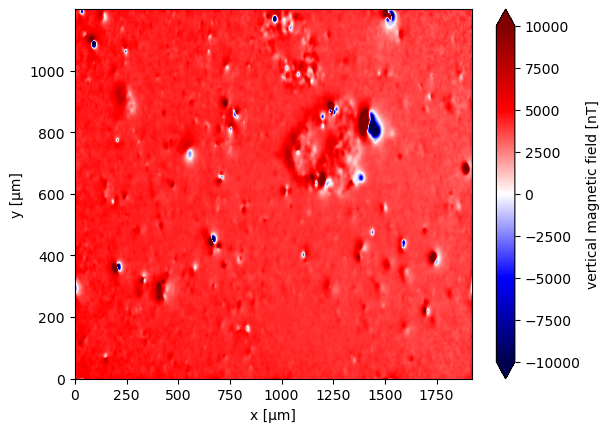

In [10]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [11]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 111MB
Dimensions:  (y: 1200, x: 1920)
Coordinates:
  * x        (x) float64 15kB 0.0 1.0 2.0 3.0 ... 1.917e+03 1.918e+03 1.919e+03
  * y        (y) float64 10kB 0.0 1.0 2.0 3.0 ... 1.197e+03 1.198e+03 1.199e+03
    z        (y, x) float64 18MB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 18MB 4.524e+03 4.611e+03 ... 4.37e+03 4.427e+03
    tga      (y, x) float64 18MB 88.8 92.76 100.1 100.5 ... 60.42 73.29 68.97
    x_deriv  (y, x) float64 18MB 87.89 83.6 68.46 45.17 ... -2.022 36.39 57.38
    y_deriv  (y, x) float64 18MB 12.57 0.475 -3.204 0.9589 ... 29.57 26.25 18.0
    z_deriv  (y, x) float64 18MB 1.969 -40.19 -72.99 ... 52.65 57.95 33.77

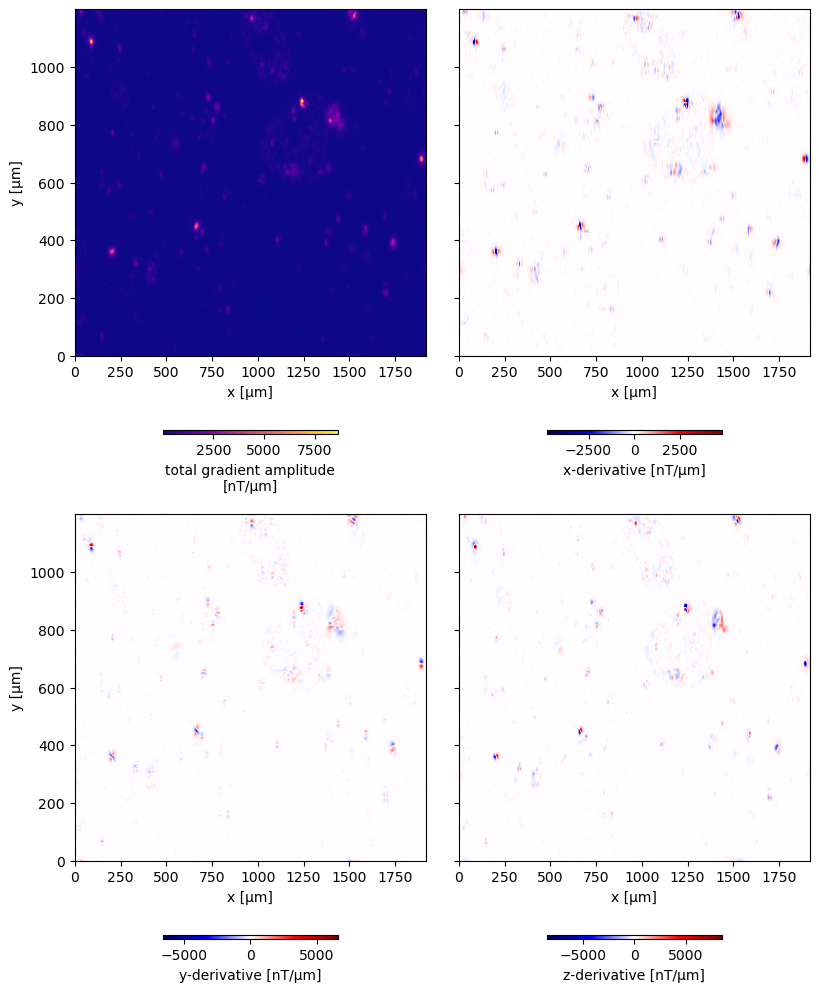

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [13]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

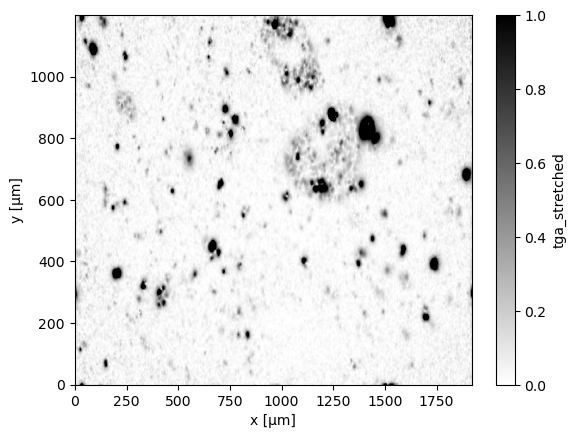

In [14]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 500],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [16]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

138 potential sources detected within 65.7601 seconds


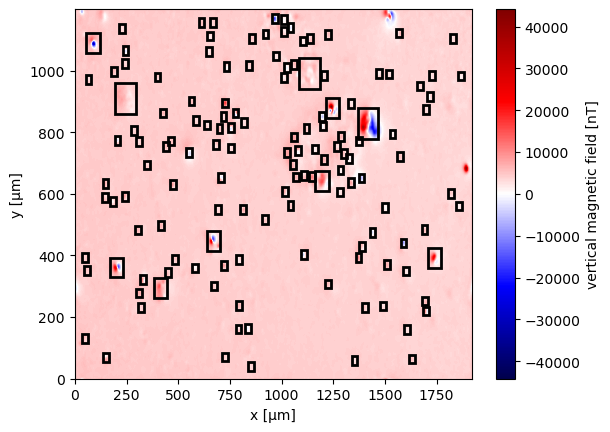

In [17]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [18]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [19]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

138 euler positions and dipole moments estimated within 2.0741 seconds


# Iterative Euler deconvolution

In [20]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameters, obs_data, coordinates):
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    # de, dn = de_orig*mg.MICROMETER_TO_METER, dn_orig*mg.MICROMETER_TO_METER
    de, dn, du = parameters[0], parameters[1], parameters[2]
    mx, my, mz = parameters[3], parameters[4], parameters[5]
    
    e, n, u = coordinates[0], coordinates[1], coordinates[2]
    # print(mx)
    # bz = np.zeros(np.shape(obs_data))
    # for i in numba.prange(e.size):
    distance = choclo.utils.distance_cartesian(
            e,
            n,
            u,
            de,
            dn,
            du,
        )

    bz = constant *(mx*choclo.point.kernel_eu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+
        
          my*choclo.point.kernel_nu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)+

          mz*choclo.point.kernel_uu(
            easting_p=e,
            northing_p=n,
            upward_p=u,
            easting_q=de,
            northing_q=dn,
            upward_q=du,
            distance=distance)
                   )
    
    Res = np.linalg.norm( (obs_data)-bz.ravel() )
    return(Res)

In [21]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [22]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [23]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [24]:
minimization

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6913.797267820717
             x: [ 1.004e+00  1.012e+00  1.265e+00  1.641e+00  5.287e-03
                 -4.431e-01]
           nit: 460
          nfev: 733
 final_simplex: (array([[ 1.004e+00,  1.012e+00, ...,  5.287e-03,
                        -4.431e-01],
                       [ 1.004e+00,  1.012e+00, ...,  5.287e-03,
                        -4.431e-01],
                       ...,
                       [ 1.004e+00,  1.012e+00, ...,  5.287e-03,
                        -4.431e-01],
                       [ 1.004e+00,  1.012e+00, ...,  5.287e-03,
                        -4.431e-01]]), array([ 6.914e+03,  6.914e+03,  6.914e+03,  6.914e+03,
                        6.914e+03,  6.914e+03,  6.914e+03]))

In [25]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 107.578 seconds


In [26]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z           bz     z_deriv
0  1370.0  778.0  10.0  2629.127149  242.315638
1  1371.0  778.0  10.0  2622.823286  252.267037
2  1372.0  778.0  10.0  2652.943037  253.897440
3  1373.0  778.0  10.0  2719.484228  247.523535
4  1374.0  778.0  10.0  2820.947262  233.418600

In [27]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
print(positions_itr[:, 2])

[703.56741395 646.91646634  -5.25638538]


In [28]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

[1369.1303638531592, 1468.8696361468408, 777.1303638531592, 876.8696361468408]

0

[1706.9941141147142, 1771.0058858852858, 359.9941141147142, 424.0058858852858]

1

[690.857864376269, 719.142135623731, 638.857864376269, 667.142135623731]

2

[1093.857864376269, 1122.142135623731, 388.85786437626905, 417.14213562373095]

3

[170.99411411471416, 235.00588588528584, 328.9941141147142, 393.0058858852858]

4

[315.85786437626905, 344.14213562373095, 306.85786437626905, 335.14213562373095]

6

[1425.857864376269, 1454.142135623731, 460.85786437626905, 489.14213562373095]

7

[230.85786437626905, 259.14213562373095, 1051.857864376269, 1080.142135623731]

8

[1683.857864376269, 1712.142135623731, 204.85786437626905, 233.14213562373095]

9

[55.994114114714165, 120.00588588528584, 1057.9941141147142, 1122.0058858852858]

10

[1215.9941141147142, 1280.0058858852858, 845.9941141147142, 910.0058858852858]

11

[739.857864376269, 768.142135623731, 800.857864376269, 829.142135623731]

12

[191.85786437626905, 220.14213562373095, 757.857864376269, 786.142135623731]

13

[1575.857864376269, 1604.142135623731, 425.85786437626905, 454.14213562373095]

14

[821.857864376269, 850.142135623731, 147.85786437626905, 176.14213562373095]

15

[1357.857864376269, 1386.142135623731, 379.85786437626905, 408.14213562373095]

16

[637.9941141147142, 702.0058858852858, 413.9941141147142, 478.0058858852858]

17

[762.857864376269, 791.142135623731, 847.857864376269, 876.142135623731]

18

[134.85786437626905, 163.14213562373095, 54.85786437626905, 83.14213562373095]

19

[1372.857864376269, 1401.142135623731, 636.857864376269, 665.142135623731]

20

[1163.9941141147142, 1228.0058858852858, 609.9941141147142, 674.0058858852858]

21

[1064.857864376269, 1093.142135623731, 725.857864376269, 754.142135623731]

22

[1182.857864376269, 1211.142135623731, 836.857864376269, 865.142135623731]

23

[458.85786437626905, 487.14213562373095, 614.857864376269, 643.142135623731]

24

[1028.857864376269, 1057.142135623731, 1124.857864376269, 1153.142135623731]

25

[170.85786437626905, 199.14213562373095, 559.857864376269, 588.142135623731]

26

[705.857864376269, 734.142135623731, 353.85786437626905, 382.14213562373095]

27

[1323.857864376269, 1352.142135623731, 622.857864376269, 651.142135623731]

28

[719.857864376269, 748.142135623731, 999.857864376269, 1028.142135623731]

29

[800.857864376269, 829.142135623731, 535.857864376269, 564.142135623731]

30

[227.85786437626905, 256.14213562373095, 577.857864376269, 606.142135623731]

31

[1011.857864376269, 1040.142135623731, 994.857864376269, 1023.142135623731]

32

[1702.857864376269, 1731.142135623731, 900.857864376269, 929.142135623731]

33

[1003.857864376269, 1032.142135623731, 592.857864376269, 621.142135623731]

34

[566.857864376269, 595.142135623731, 344.85786437626905, 373.14213562373095]

35

[952.857864376269, 981.142135623731, 1153.857864376269, 1182.142135623731]

36

[1184.857864376269, 1213.142135623731, 805.857864376269, 834.142135623731]

37

[638.857864376269, 667.142135623731, 1097.857864376269, 1126.142135623731]

38

[1485.857864376269, 1514.142135623731, 540.857864376269, 569.142135623731]

39

[539.857864376269, 568.142135623731, 719.857864376269, 748.142135623731]

40

[382.9941141147142, 447.0058858852858, 260.9941141147142, 325.0058858852858]

41

[1132.857864376269, 1161.142135623731, 642.857864376269, 671.142135623731]

42

[632.857864376269, 661.142135623731, 1047.857864376269, 1076.142135623731]

43

[1373.857864376269, 1402.142135623731, 414.85786437626905, 443.14213562373095]

44

[781.857864376269, 810.142135623731, 371.85786437626905, 400.14213562373095]

45

[1457.857864376269, 1486.142135623731, 975.857864376269, 1004.142135623731]

46

[1554.857864376269, 1583.142135623731, 1107.857864376269, 1136.142135623731]

47

[1677.857864376269, 1706.142135623731, 469.85786437626905, 498.14213562373095]

48

[1852.857864376269, 1881.142135623731, 967.857864376269, 996.142135623731]

49

[1274.857864376269, 1303.142135623731, 770.857864376269, 799.142135623731]

50

[400.85786437626905, 429.14213562373095, 481.85786437626905, 510.14213562373095]

51

[777.857864376269, 806.142135623731, 146.85786437626905, 175.14213562373095]

52

[413.85786437626905, 442.14213562373095, 847.857864376269, 876.142135623731]

53

[685.857864376269, 714.142135623731, 796.857864376269, 825.142135623731]

54

[133.85786437626905, 162.14213562373095, 619.857864376269, 648.142135623731]

55

[295.85786437626905, 324.14213562373095, 263.85786437626905, 292.14213562373095]

56

[1270.857864376269, 1299.142135623731, 662.857864376269, 691.142135623731]

57

[669.857864376269, 698.142135623731, 744.857864376269, 773.142135623731]

58

[780.857864376269, 809.142135623731, 222.85786437626905, 251.14213562373095]

59

[1085.1303638531592, 1184.8696361468408, 941.1303638531592, 1040.8696361468408]

60

[1210.857864376269, 1239.142135623731, 1101.857864376269, 1130.142135623731]

61

[826.857864376269, 855.142135623731, 1002.857864376269, 1031.142135623731]

62

[1497.857864376269, 1526.142135623731, 356.85786437626905, 385.14213562373095]

63

[626.857864376269, 655.142135623731, 808.857864376269, 837.142135623731]

64

[997.857864376269, 1026.142135623731, 962.857864376269, 991.142135623731]

65

[659.857864376269, 688.142135623731, 286.85786437626905, 315.14213562373095]

66

[51.85786437626905, 80.14213562373095, 955.857864376269, 984.142135623731]

67

[214.85786437626905, 243.14213562373095, 1121.857864376269, 1150.142135623731]

68

[1338.857864376269, 1367.142135623731, 43.85786437626905, 72.14213562373095]

69

[1089.857864376269, 1118.142135623731, 1081.857864376269, 1110.142135623731]

70

[131.85786437626905, 160.14213562373095, 574.857864376269, 603.142135623731]

71

[1655.857864376269, 1684.142135623731, 935.857864376269, 964.142135623731]

72

[704.857864376269, 733.142135623731, 835.857864376269, 864.142135623731]

73

[1254.857864376269, 1283.142135623731, 739.857864376269, 768.142135623731]

74

[1558.857864376269, 1587.142135623731, 706.857864376269, 735.142135623731]

75

[1845.857864376269, 1874.142135623731, 545.857864376269, 574.142135623731]

76

[295.85786437626905, 324.14213562373095, 754.857864376269, 783.142135623731]

77

[1145.857864376269, 1174.142135623731, 730.857864376269, 759.142135623731]

78

[1589.857864376269, 1618.142135623731, 334.85786437626905, 363.14213562373095]

79

[1322.857864376269, 1351.142135623731, 878.857864376269, 907.142135623731]

80

[549.857864376269, 578.142135623731, 886.857864376269, 915.142135623731]

81

[426.85786437626905, 455.14213562373095, 738.857864376269, 767.142135623731]

82

[1387.857864376269, 1416.142135623731, 216.85786437626905, 245.14213562373095]

83

[1045.857864376269, 1074.142135623731, 769.857864376269, 798.142135623731]

84

[1190.857864376269, 1219.142135623731, 696.857864376269, 725.142135623731]

85

[571.857864376269, 600.142135623731, 823.857864376269, 852.142135623731]

86

[1095.857864376269, 1124.142135623731, 644.857864376269, 673.142135623731]

87

[996.857864376269, 1025.142135623731, 1150.857864376269, 1179.142135623731]

88

[1209.857864376269, 1238.142135623731, 292.85786437626905, 321.14213562373095]

89

[598.857864376269, 627.142135623731, 1141.857864376269, 1170.142135623731]

90

[1477.857864376269, 1506.142135623731, 221.85786437626905, 250.14213562373095]

91

[176.85786437626905, 205.14213562373095, 983.857864376269, 1012.142135623731]

92

[1682.857864376269, 1711.142135623731, 859.857864376269, 888.142135623731]

93

[33.85786437626905, 62.14213562373095, 116.85786437626905, 145.14213562373095]

94

[803.857864376269, 832.142135623731, 816.857864376269, 845.142135623731]

95

[1288.857864376269, 1317.142135623731, 716.857864376269, 745.142135623731]

96

[292.85786437626905, 321.14213562373095, 467.85786437626905, 496.14213562373095]

97

[334.85786437626905, 363.14213562373095, 678.857864376269, 707.142135623731]

98

[905.857864376269, 934.142135623731, 501.85786437626905, 530.142135623731]

99

[1711.857864376269, 1740.142135623731, 968.857864376269, 997.142135623731]

100

[1122.857864376269, 1151.142135623731, 1089.857864376269, 1118.142135623731]

101

[1805.857864376269, 1834.142135623731, 586.857864376269, 615.142135623731]

102

[196.13036385315928, 295.8696361468407, 860.1303638531592, 959.8696361468408]

103

[470.85786437626905, 499.14213562373095, 372.85786437626905, 401.14213562373095]

104

[1106.857864376269, 1135.142135623731, 797.857864376269, 826.142135623731]

105

[385.85786437626905, 414.14213562373095, 964.857864376269, 993.142135623731]

106

[1615.857864376269, 1644.142135623731, 49.85786437626905, 78.14213562373095]

107

[434.85786437626905, 463.14213562373095, 329.85786437626905, 358.14213562373095]

108

[652.857864376269, 681.142135623731, 1142.857864376269, 1171.142135623731]

109

[1522.857864376269, 1551.142135623731, 779.857864376269, 808.142135623731]

110

[1681.857864376269, 1710.142135623731, 237.85786437626905, 266.14213562373095]

111

[713.857864376269, 742.142135623731, 55.85786437626905, 84.14213562373095]

112

[1055.857864376269, 1084.142135623731, 639.857864376269, 668.142135623731]

113

[272.85786437626905, 301.14213562373095, 790.857864376269, 819.142135623731]

114

[226.85786437626905, 255.14213562373095, 1008.857864376269, 1037.142135623731]

115

[1816.857864376269, 1845.142135623731, 1088.857864376269, 1117.142135623731]

116

[907.857864376269, 936.142135623731, 1104.857864376269, 1133.142135623731]

117

[1028.857864376269, 1057.142135623731, 546.857864376269, 575.142135623731]

118

[1503.857864376269, 1532.142135623731, 974.857864376269, 1003.142135623731]

119

[677.857864376269, 706.142135623731, 535.857864376269, 564.142135623731]

120

[1590.857864376269, 1619.142135623731, 145.85786437626905, 174.14213562373095]

121

[1039.857864376269, 1068.142135623731, 679.857864376269, 708.142135623731]

122

[43.85786437626905, 72.14213562373095, 337.85786437626905, 366.14213562373095]

123

[304.85786437626905, 333.14213562373095, 215.85786437626905, 244.14213562373095]

124

[842.857864376269, 871.142135623731, 1088.857864376269, 1117.142135623731]

125

[1010.857864376269, 1039.142135623731, 720.857864376269, 749.142135623731]

126

[837.857864376269, 866.142135623731, 24.85786437626905, 53.14213562373095]

127

[957.857864376269, 986.142135623731, 1032.857864376269, 1061.142135623731]

128

[740.857864376269, 769.142135623731, 734.857864376269, 763.142135623731]

129

[1313.857864376269, 1342.142135623731, 700.857864376269, 729.142135623731]

130

[1266.857864376269, 1295.142135623731, 591.857864376269, 620.142135623731]

131

[1047.857864376269, 1076.142135623731, 1004.857864376269, 1033.142135623731]

132

[1189.857864376269, 1218.142135623731, 969.857864376269, 998.142135623731]

133

[35.85786437626905, 64.14213562373095, 377.85786437626905, 406.14213562373095]

134

[996.857864376269, 1025.142135623731, 1111.857864376269, 1140.142135623731]

135

[450.85786437626905, 479.14213562373095, 756.857864376269, 785.142135623731]

136

[1358.857864376269, 1387.142135623731, 756.857864376269, 785.142135623731]

137

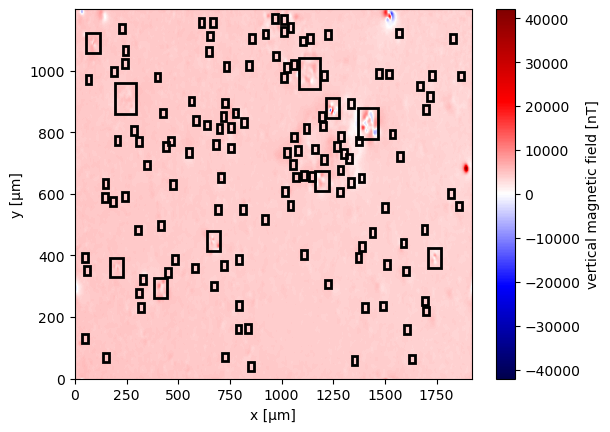

In [29]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

###################################################

# ax = plt.subplot(111)
# data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
# for window in windows:
#     rect = matplotlib.patches.Rectangle(
#         xy=[window[0], window[2]],
#         width=window[1] - window[0],
#         height=window[3] - window[2],
#         edgecolor="k",
#         fill=False,
#         linewidth=2,
#     )
#     ax.add_patch(rect)   

##################################################

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    print(window)
    print(index)
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    # # store the results with the itr Euler (without interfering sources)
    # print(estimated_dipole_moments_itr_euler[index])
    # print(positions_itr[:, index])
    # estimated_dipole_moments_itr_euler[index] = moment
    # positions_itr[:, index] = position

    # print(moment)
    # print(position)
    # print()
    # #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

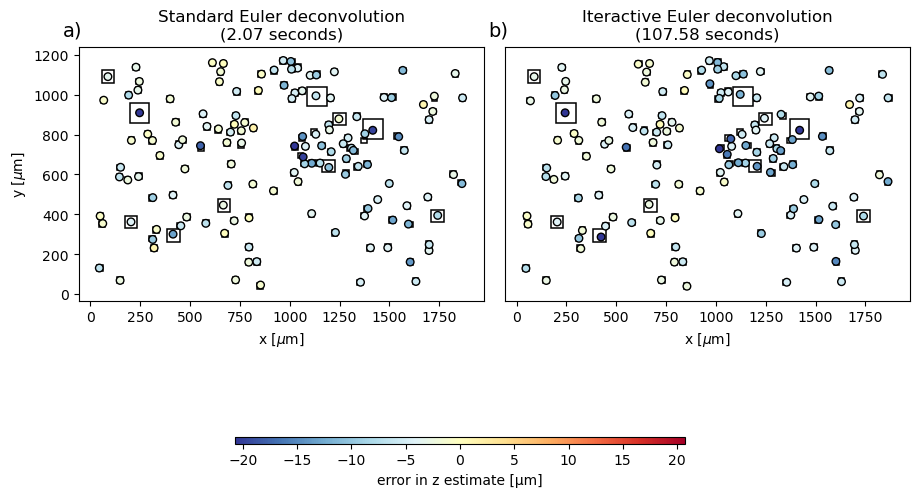

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [31]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

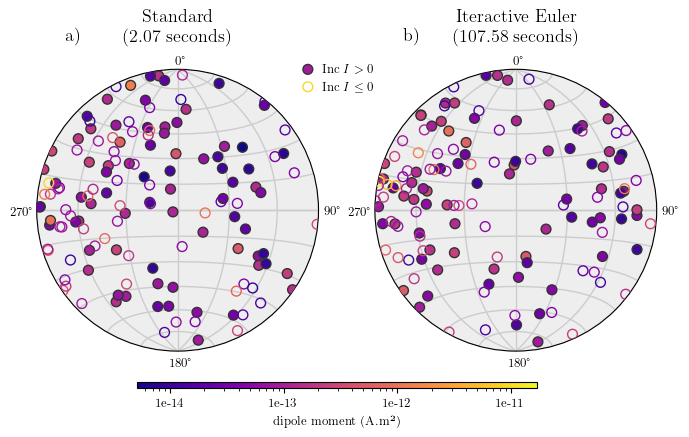

In [32]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

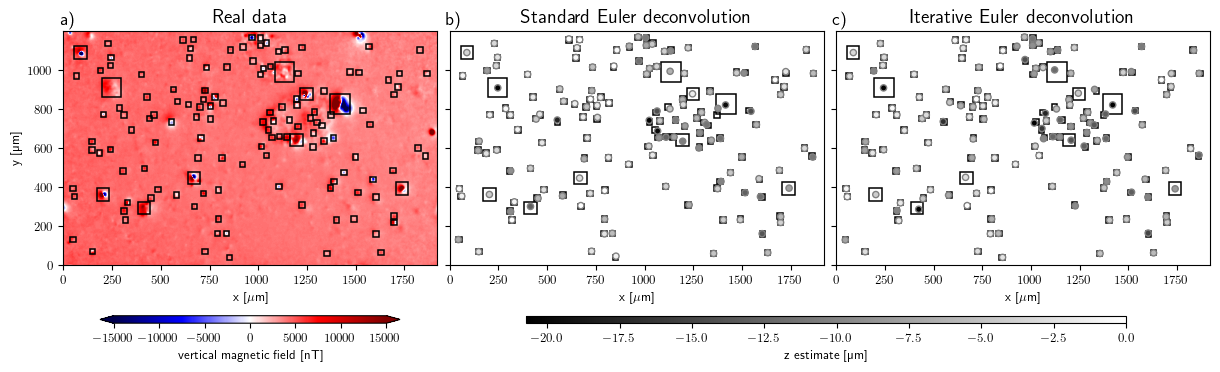

In [33]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


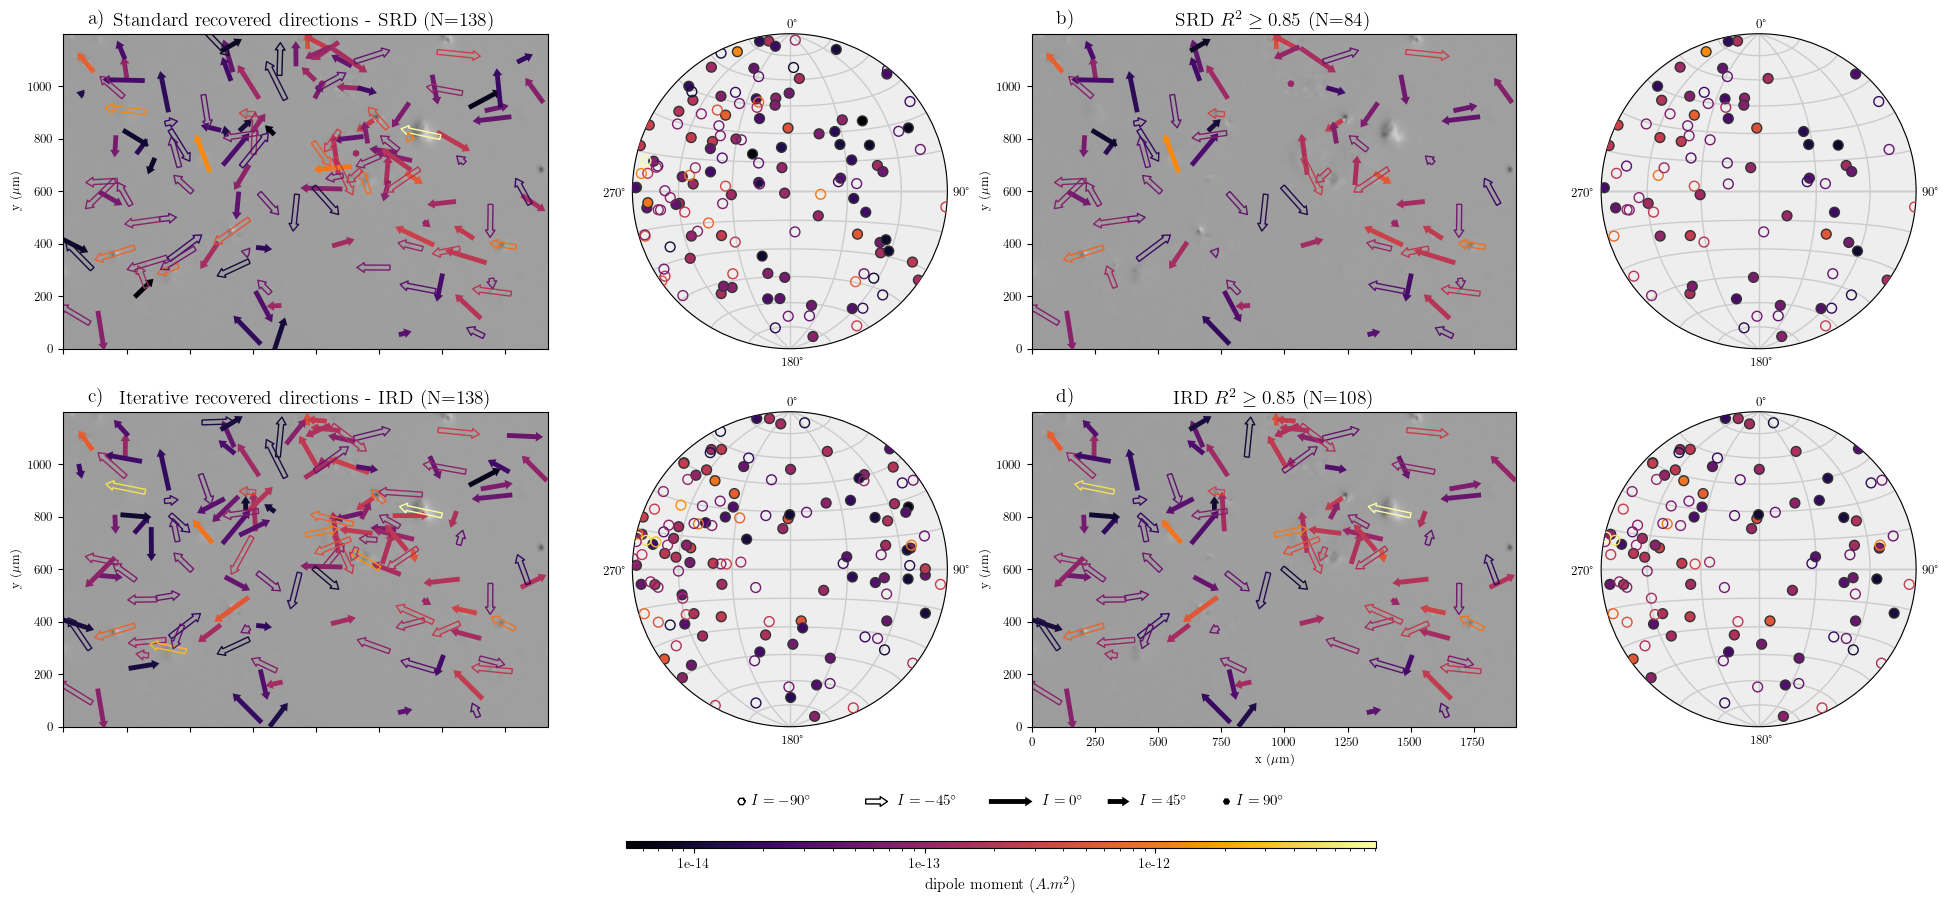

In [34]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

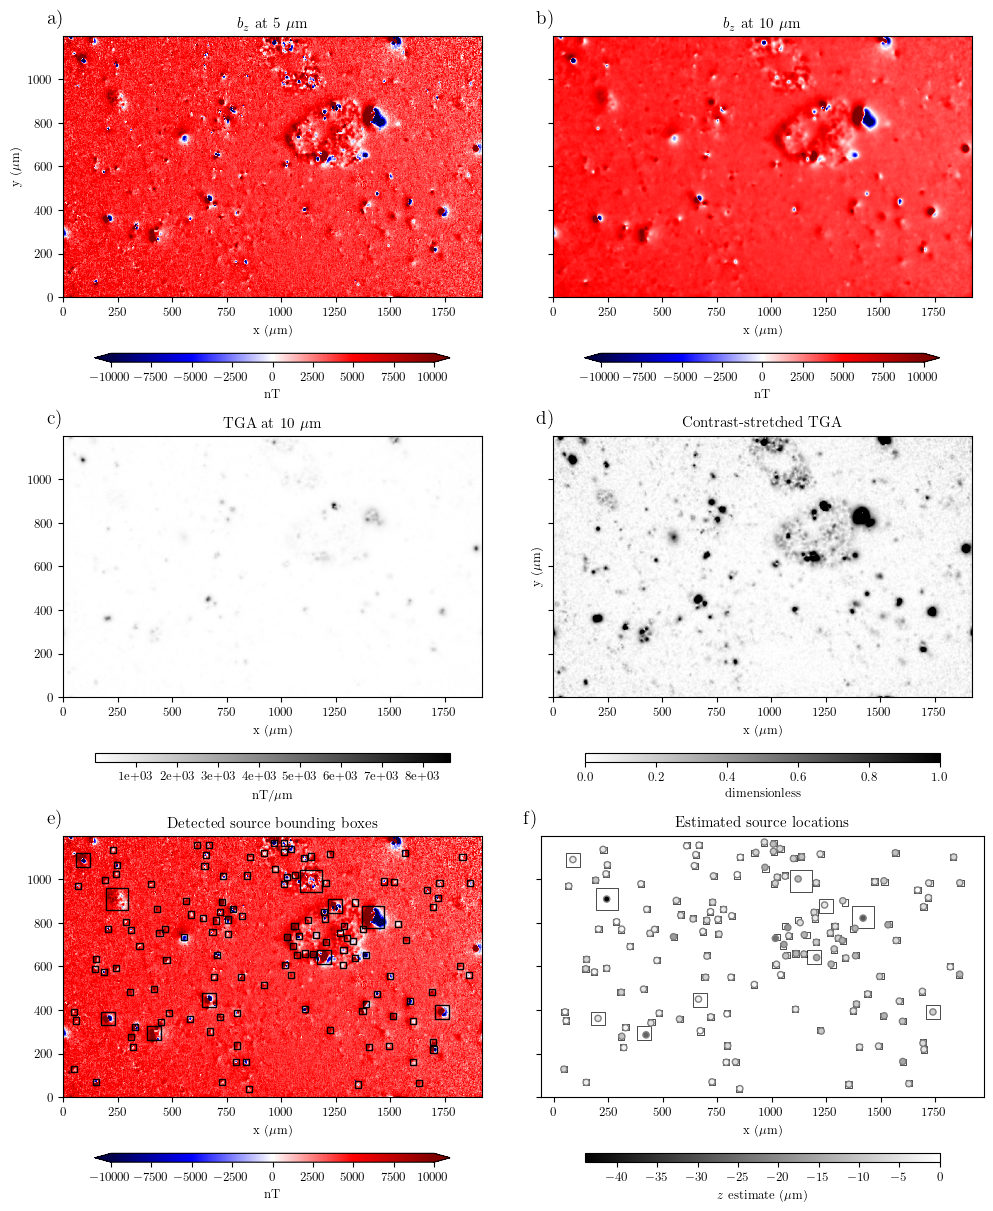

In [35]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [36]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [37]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 111MB
Dimensions:  (y: 1200, x: 1920)
Coordinates:
  * x        (x) float64 15kB 0.0 1.0 2.0 3.0 ... 1.917e+03 1.918e+03 1.919e+03
  * y        (y) float64 10kB 0.0 1.0 2.0 3.0 ... 1.197e+03 1.198e+03 1.199e+03
    z        (y, x) float64 18MB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 18MB 4.516e+03 4.604e+03 ... 4.363e+03 4.42e+03
    tga      (y, x) float64 18MB 88.28 92.4 99.98 100.6 ... 60.12 72.69 68.31
    x_deriv  (y, x) float64 18MB 87.24 82.97 67.88 44.66 ... -2.651 35.68 56.63
    y_deriv  (y, x) float64 18MB 13.45 1.474 -2.099 2.152 ... 30.13 26.92 18.78
    z_deriv  (y, x) float64 18MB 1.455 -40.62 -73.38 ... 51.95 57.33 33.27

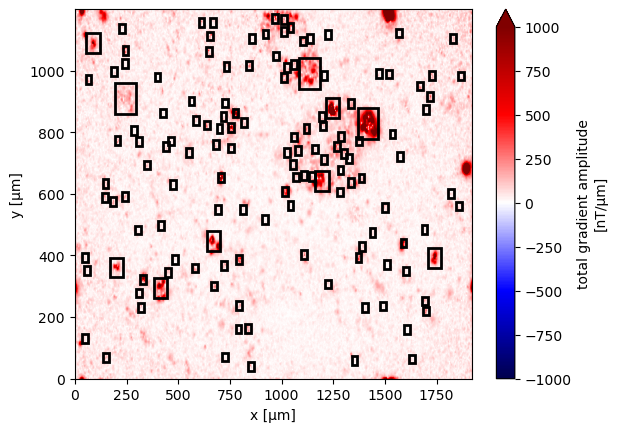

In [38]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [39]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [40]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.1,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [41]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

158 potential sources detected within 11.3866 seconds


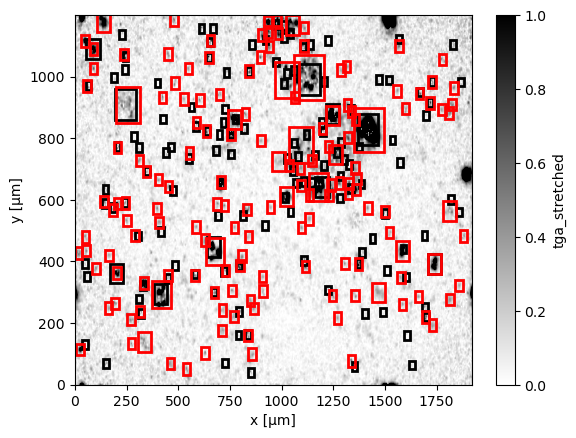

In [42]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [43]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 106.33732969  169.66267031 1145.33732969 1208.66267031]
[ 914.61522369  951.38477631 1158.61522369 1195.38477631]
[ -1.38477631  35.38477631 408.61522369 445.38477631]
[1303.61522369 1340.38477631  783.61522369  820.38477631]
[293.61522369 330.38477631 709.61522369 746.38477631]
[1796.61522369 1833.38477631  258.61522369  295.38477631]
[443.61522369 480.38477631  50.61522369  87.38477631]
[1116.61522369 1153.38477631  597.61522369  634.38477631]
[1115.61522369 1152.38477631  519.61522369  556.38477631]
[693.61522369 730.38477631 157.61522369 194.38477631]
[1807.61522369 1844.38477631  890.61522369  927.38477631]
[847.61522369 884.38477631 229.61522369 266.38477631]
[1439.33732969 1502.66267031  267.33732969  330.66267031]
[1398.61522369 1435.38477631  554.61522369  591.38477631]
[1077.61522369 1114.38477631  491.61522369  528.38477631]
[1792.61522369 1829.38477631  863.61522369  900.38477631]
[303.33732969 366.66267031 106.33732969 169.66267031]
[  71.6152236

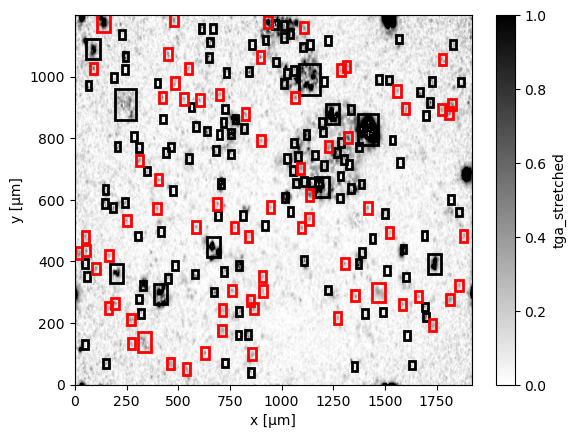

In [44]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [45]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 136.06984526 1178.67483331  -11.57156007]

[-4.03447331e-13  1.81725430e-13 -5.68149572e-14]

(7.316712429285089, -65.75169312608989, 4.461186164675238e-13)

0.9507014421514655

[ 933.66971634 1175.73382748   -2.56587142]

[4.34288247e-14 2.97903344e-14 3.28418337e-14]

(-31.947967215042034, 55.55152766545654, 6.206539197193062e-14)

0.8206931440571201

[  8.00314796 424.74960903  -5.44346688]

[ 2.43787582e-14 -1.27125075e-14  1.45086290e-14]

(-27.820502076710063, 117.54016570249497, 3.108748966569821e-14)

0.6627909541352601

[1324.23343909  807.4750078   -20.94930515]

[-4.99188034e-13  2.37415493e-13 -8.49027717e-14]

(8.732108915485897, -64.5640837118264, 5.592524383815336e-13)

0.9526929630490567

[312.24896536 728.14385561  -2.99707565]

[-1.46029392e-14 -9.21109033e-15 -3.02674142e-16]

(1.004337667931923, -122.2424835181249, 1.7267936487342387e-14)

0.9782980018907265

[1818.72045549  277.56530392  -14.40887089]

[-9.41112806e-14 -8.81239627e-15  8.81850031e-14]

(-43.013260828170836, -95.34946627662778, 1.2927175348044087e-13)

0.9240508282695756

[464.76957691  66.65941034  -7.32491445]

[-2.27828374e-14  3.09981444e-14  2.05761871e-14]

(-28.140672783283524, -36.31492781656381, 4.3627080045330454e-14)

0.9331527130504922

[1147.69323434  622.12815005   -6.20006873]

[ 5.81679524e-14  5.21293860e-14 -7.80320324e-15]

(5.705018136568839, 48.13370488896087, 7.849760219183927e-14)

0.7729181960282852

[1136.50326788  540.12272989   -7.96432872]

[ 1.44257735e-14  2.53569872e-15 -2.89883401e-14]

(63.19390479599384, 80.03064310400205, 3.247855555168927e-14)

0.9626596096834348

[709.34444262 176.11493393  -9.36175227]

[-6.64835355e-14  1.93215130e-14 -1.01630808e-14]

(8.350959221447471, -73.79502486098895, 6.997620715376775e-14)

0.9707790910709754

[1823.10546602  906.08160671  -14.19999464]

[-1.74919610e-13  1.28270587e-14 -1.98547349e-14]

(6.458604614919832, -85.80594080496395, 1.7650952916223274e-13)

0.9113566877438314

[868.83440126 245.15532121  -6.62641698]

[-3.82542710e-14  6.61290835e-15  1.09366394e-14]

(-15.733325462845176, -80.19236705959958, 4.0332739626832784e-14)

0.8943043965004056

[1475.08441919  296.3970635   -14.78299465]

[-2.04152548e-13 -4.63069978e-15  7.62243858e-15]

(-2.137708502489805, -91.29939140176133, 2.0434727257817476e-13)

0.9021624855032653

[1414.11755461  570.35302802   -3.1610133 ]

[-7.18946963e-15 -9.59644692e-15 -5.54622689e-15]

(24.822363610488324, -143.16016953598876, 1.3211392796636082e-14)

0.9630309225221309

[1094.06730913  512.08664673   -3.973543  ]

[-1.12168863e-14  1.04308154e-14 -5.89198620e-15]

(21.039815812342283, -47.07960939895961, 1.64114578706713e-14)

0.9683929059333161

[1813.96883137  888.43688714  -14.21980647]

[-2.16406651e-14 -1.10556456e-13  8.32160200e-14]

(-36.45265748737543, -168.9247790409557, 1.4005696808299625e-13)

0.8703816124559535

piorou

[336.82510124 134.6131474   -2.68137912]

[ 8.20190595e-15 -7.45135172e-15  5.32485373e-17]

(-0.275320512341036, 132.25484113534742, 1.1081369003976212e-14)

0.10535997016287846

[  86.98601129 1030.82236629   -3.28385897]

[-8.44643335e-15  1.84071447e-14  1.07260089e-16]

(-0.3034431323781972, -24.648833645686924, 2.0252820013129444e-14)

0.8260512771404703

[1738.44715397  193.08656858  -16.31100509]

[-1.43876226e-13 -2.38753438e-14  8.59988313e-14]

(-30.526328249489083, -99.42201042049165, 1.6931095484330112e-13)

0.9613893262905906

piorou

[8.96392024e+02 1.06705764e+03 1.10673988e-01]

[-2.64388282e-15 -3.99581587e-15  2.35350449e-15]

(-26.16039160152795, -146.50887506810992, 5.338131156710262e-15)

0.6220058170031851

[ 1.93082396e+02  2.62148233e+02 -1.49199420e-01]

[-6.00068740e-15  1.67893061e-15  2.06109828e-15]

(-18.30287642578319, -74.36892672990088, 6.563168698306951e-15)

0.7644568018933691

[ 4.49856287e+02  1.07305309e+03 -6.95688838e-01]

[-2.78213560e-15  7.30176304e-15  2.83171414e-15]

(-19.920388234713908, -20.857963499336286, 8.311114663408185e-15)

0.8464918452059806

[823.68110482 876.60466374  -8.93350494]

[5.91617755e-15 3.55966982e-14 8.41310338e-16]

(-1.3355915646235672, 9.436314738351367, 3.609479024066444e-14)

0.805764307078646

[421.91491555 933.97823646  -4.93462053]

[-5.08264845e-16  1.72120642e-14 -5.28218833e-15]

(17.053657108696793, -1.691428175269462, 1.8011524106164084e-14)

0.8872970093681505

[1228.05997858  773.13728168  -20.31833411]

[ 2.14651089e-13 -1.43521268e-13  1.70575969e-13]

(-33.44892274228967, 123.7677110695896, 3.094666470212154e-13)

0.9778131948172679

[1313.12167205 1025.20231399  -12.43783001]

[-1.85750095e-15  7.08465227e-14  4.78914815e-14]

(-34.049133824072854, -1.5018745332552539, 8.553522130366385e-14)

0.9192153715335251

[400.76046336 574.31720746  -5.60047142]

[-3.92404643e-15 -2.09735756e-14  2.39130617e-15]

(-6.394488803554244, -169.40277549450366, 2.1471081966060777e-14)

0.762256110903786

[ 96.41704603 372.12547773  -0.68670176]

[-3.15989755e-15 -6.81714474e-15  2.12870522e-16]

(-1.6227726079799212, -155.13123269305504, 7.51689621895108e-15)

0.631450302368339

[1561.84453463  956.78304609   -3.42754555]

[-1.73591738e-15 -9.45891300e-15  8.68170681e-15]

(-42.07435990068699, -169.6006915952663, 1.2955943709384446e-14)

0.8773701449790691

[722.31472231 244.20454821  -2.39184158]

[ 5.33293716e-15  8.14223558e-15 -4.60066483e-15]

(25.298927443852957, 33.22368026844889, 1.0765794719421171e-14)

0.6768124953875311

[ 475.57731533 1186.41311173   -3.11960955]

[-8.36612042e-15  1.25139654e-14 -8.23227332e-15]

(28.673707077382698, -33.76441904308556, 1.7156970168201287e-14)

0.8210529656136759

[ 547.84862809 1025.09588981   -2.25585068]

[-1.26954337e-15 -2.50471047e-15  7.15500117e-15]

(-68.5717806295699, -153.12126729500378, 7.686309687860349e-15)

0.808511382112843

[1857.42933991  319.19306655   -4.65765608]

[-1.07329854e-14 -6.94316267e-15 -1.06338255e-14]

(39.75618955931603, -122.89880701409966, 1.6627769837093412e-14)

0.9316085529864244

[1270.45335315  215.35850897   -4.60318453]

[-1.46647999e-14 -5.38908718e-15 -8.20022154e-15]

(27.693154411147727, -110.17759948284333, 1.7644893010179648e-14)

0.9427852014554781

[248.18243803 529.67152454  -0.76087899]

[1.15125730e-15 5.36584911e-15 1.84128118e-15]

(-18.54725818830706, 12.109380667822494, 5.7886135145630564e-15)

0.6967148397183571

[1090.66332295  705.55835121   -9.58083279]

[-3.52063502e-14  2.53460643e-14 -3.15169678e-14]

(35.99899336746138, -54.248800779992976, 5.3621164880705155e-14)

0.5720216859030378

[1064.45239335  936.17813872   -5.18473281]

[-1.47088244e-14  2.20235432e-14 -4.69451779e-15]

(10.051876521156217, -33.73770184056092, 2.6896551212288737e-14)

0.8618891773577348

piorou

[703.99506273 943.29107288  -0.98350551]

[-3.51995269e-16 -5.94481743e-15  2.41616440e-15]

(-22.083451226298664, -176.61144781489557, 6.426710309889742e-15)

0.5083203365219271

[625.75442474 101.03264193  -3.21232502]

[-7.02788180e-15 -1.78109487e-15 -6.28931632e-15]

(40.94112517908442, -104.22120184651654, 9.597860246138094e-15)

0.8685082287993557

[1354.33404228  291.33683426   -4.2144989 ]

[-1.38574314e-14  1.01474978e-14  2.18665847e-15]

(-7.255417500377129, -53.785487294448764, 1.7314202080233817e-14)

0.8934390339298371

[ 54.18520446 477.11544372  -2.66798968]

[ 3.24579048e-15 -1.25641292e-14 -1.73196614e-15]

(7.6022394275797796, 165.5150222666881, 1.3091684531138961e-14)

0.8654130477023572

[762.78847481 303.39523665  -1.70020917]

[-8.66718737e-15  6.96821261e-16  2.35228227e-15]

(-15.137766427914062, -85.40344223037499, 9.00771495280943e-15)

0.8528123034071061

[ 53.59301456 439.75188616  -2.44846209]

[-6.51331046e-15  6.27168022e-15 -5.98875358e-15]

(33.51764577008316, -46.082734069349435, 1.0845384059783692e-14)

0.7708763612733373

[546.41157478  45.96519667  -6.26497871]

[ 2.83557993e-15 -2.92116376e-14 -1.24207811e-15]

(2.4233717209412213, 174.4556569375954, 2.937521133911516e-14)

0.8315699781211551

[403.24862692 665.53525589  -4.95552482]

[-6.70337780e-15  9.13905459e-15 -8.58941774e-15]

(37.15670554248657, -36.259563008184394, 1.4220959528060138e-14)

0.7118028476080136

piorou

[687.24610217 591.29419123  -2.51249651]

[-8.90285518e-15  6.29867162e-15 -9.35396465e-17]

(0.49142191696969034, -54.721015391805224, 1.0906092069540332e-14)

0.570765406903318

[851.91126424  93.10168784  -6.95592765]

[-4.19966422e-14 -4.04140195e-15 -3.89640947e-15]

(5.276438232630271, -95.49673581376685, 4.237018868175628e-14)

0.8999547720960873

[272.10386972 213.35650192  -3.94447935]

[-1.85675035e-14 -7.94019771e-15  7.02870685e-15]

(-19.19089231386949, -113.15346469601002, 2.138227411365575e-14)

0.6606714538203559

piorou

[604.28190909 928.20968327   0.934216  ]

[ 1.36047439e-16  2.95925878e-15 -1.19514769e-15]

(21.97117458632513, 2.6322332446662764, 3.1943856077857473e-15)

0.5301129313078379

[905.24295726 348.71886731  -4.60733942]

[1.60137550e-14 7.96110851e-15 4.84502864e-15]

(-15.158785617230292, 63.56610446813237, 1.8528192082260504e-14)

0.9094464681676625

[161.51556612 251.87765274  -4.93349494]

[ 7.46132082e-15 -1.90491427e-14  9.53672302e-16]

(-2.66893775020411, 158.61031684144496, 2.0480494029153173e-14)

0.9002947280747591

[1778.83224899  896.84415639   -6.89174137]

[ 1.87941083e-14  2.94178958e-14 -1.94434468e-15]

(3.187948293757453, 32.57314641490868, 3.496300292863098e-14)

0.8865774774981278

[159.56455249 419.04668569  -3.38466999]

[1.14433166e-14 4.75661482e-15 1.42215290e-15]

(-6.546559673526387, 67.4289316034519, 1.2473868580190878e-14)

0.7809753903953942

[1303.71664347  392.87607265   -3.76333498]

[-2.66936729e-15  1.03694321e-14 -5.43153417e-15]

(26.89705194133438, -14.436019151308088, 1.2006340326007714e-14)

0.8505049743195703

[1884.53439223  478.94532527   -2.09596204]

[ 6.58225318e-15 -4.05141068e-15 -4.27036170e-15]

(28.92064046066567, 121.61251079778962, 8.830400584464646e-15)

0.6867451584887068

[1580.55416983  261.55515216   -4.3533667 ]

[1.49730427e-14 1.16594441e-15 2.05267070e-15]

(-7.782810466164821, 85.54738744449224, 1.5157997625707238e-14)

0.7992707283132865

[1101.51848406 1163.24201439   -5.03925923]

[-1.07938290e-14  2.94396786e-14  3.94519798e-15]

(-7.171236633693226, -20.135068500946442, 3.160325947565089e-14)

0.8540410871661646

[946.23073322 576.93064286  -3.87949888]

[-9.39510417e-15  9.52548237e-15 -1.89418640e-15]

(8.058211496319744, -44.60519180088818, 1.3512614065752732e-14)

0.918768678255811

[1665.52951219  288.15465197   -2.28543961]

[ 4.68140251e-15  4.52697326e-15 -5.11622297e-15]

(38.1543882658514, 45.960789929885365, 8.281591264097687e-15)

0.8898961378807384

[1526.10629821  493.08916001  -14.33188111]

[-7.75730476e-14 -8.29789507e-15  1.45300166e-14]

(-10.550177143123411, -96.10564328855905, 7.935713047170582e-14)

0.8253887846002794

[1592.69553656  893.10248944  -12.51957019]

[-8.16133695e-14 -1.03036078e-14 -2.83182975e-14]

(18.995947418676085, -97.19546803255037, 8.699903667426237e-14)

0.8875133734341399

[526.41235714 926.18161376  -5.35747898]

[-2.14299346e-16  2.63756204e-16  1.40410905e-14]

(-88.61352479123691, -39.093522715670765, 1.4045202491283294e-14)

0.84725727042656

[898.87529582 790.5634304   -5.48566856]

[-1.65913744e-14  2.05768793e-15 -1.06546064e-14]

(32.509155125714834, -82.93018898978328, 1.98249444270853e-14)

0.9202310362604071

[840.26739952 482.68633856  -8.07371071]

[-3.80178966e-14 -7.17274744e-15 -3.35460853e-15]

(4.9556025795857, -100.68427120902285, 3.883377610562099e-14)

0.9379787245288096

[269.40737413 139.99999262  -1.17767301]

[-2.96001441e-15  5.93661995e-15 -9.67040336e-16]

(8.294057356077364, -26.50096537624657, 6.703753329442665e-15)

0.7234805895339795

piorou

[1290.27188754 1025.59777399   -3.50087622]

[-2.27356457e-15  1.09222385e-14 -2.86264872e-15]

(14.391240860193186, -11.758727272217227, 1.1517775250388884e-14)

0.5359577751049474

[ 4.84973658e+02  9.80753456e+02 -8.81953951e-01]

[-1.19345399e-15 -7.10386138e-15 -6.95723873e-16]

(5.516659437463944, -170.46332284435456, 7.236933785368054e-15)

0.8213831479541134

[584.08164431 511.3621578   -4.98454013]

[7.14244274e-15 1.43537244e-14 1.48062333e-15]

(-5.276348378826267, 26.455032051938346, 1.610081170884149e-14)

0.7896699634973617

[769.7770614  510.33955551  -4.7071445 ]

[-9.16133753e-15 -8.90146171e-15 -7.04138903e-15]

(28.865457439946084, -134.17572241162975, 1.4585859087713512e-14)

0.9175384999982235

[1779.34696022 1056.40123061   -7.57208798]

[ 1.89177101e-14 -2.05760114e-14 -1.40499502e-14]

(26.687105406295938, 137.40437932684276, 3.128343175377686e-14)

0.8598462032716456

[849.19146486 275.09115698  -6.91520349]

[ 4.95057820e-15  1.22085175e-14 -2.25710522e-14]

(59.72912708069657, 22.07265239105676, 2.6134431716246617e-14)

0.8422926369244897

[911.21708709 303.71490883  -4.41530173]

[-6.17779734e-15  1.70948081e-15  9.15427075e-15]

(-54.99973049632219, -74.53250744222171, 1.1175337918364e-14)

0.7709107802968114

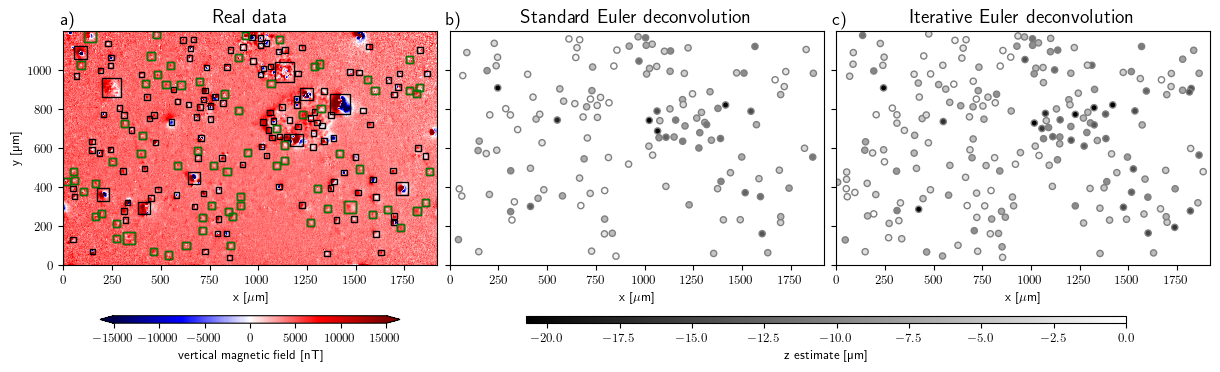

In [55]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


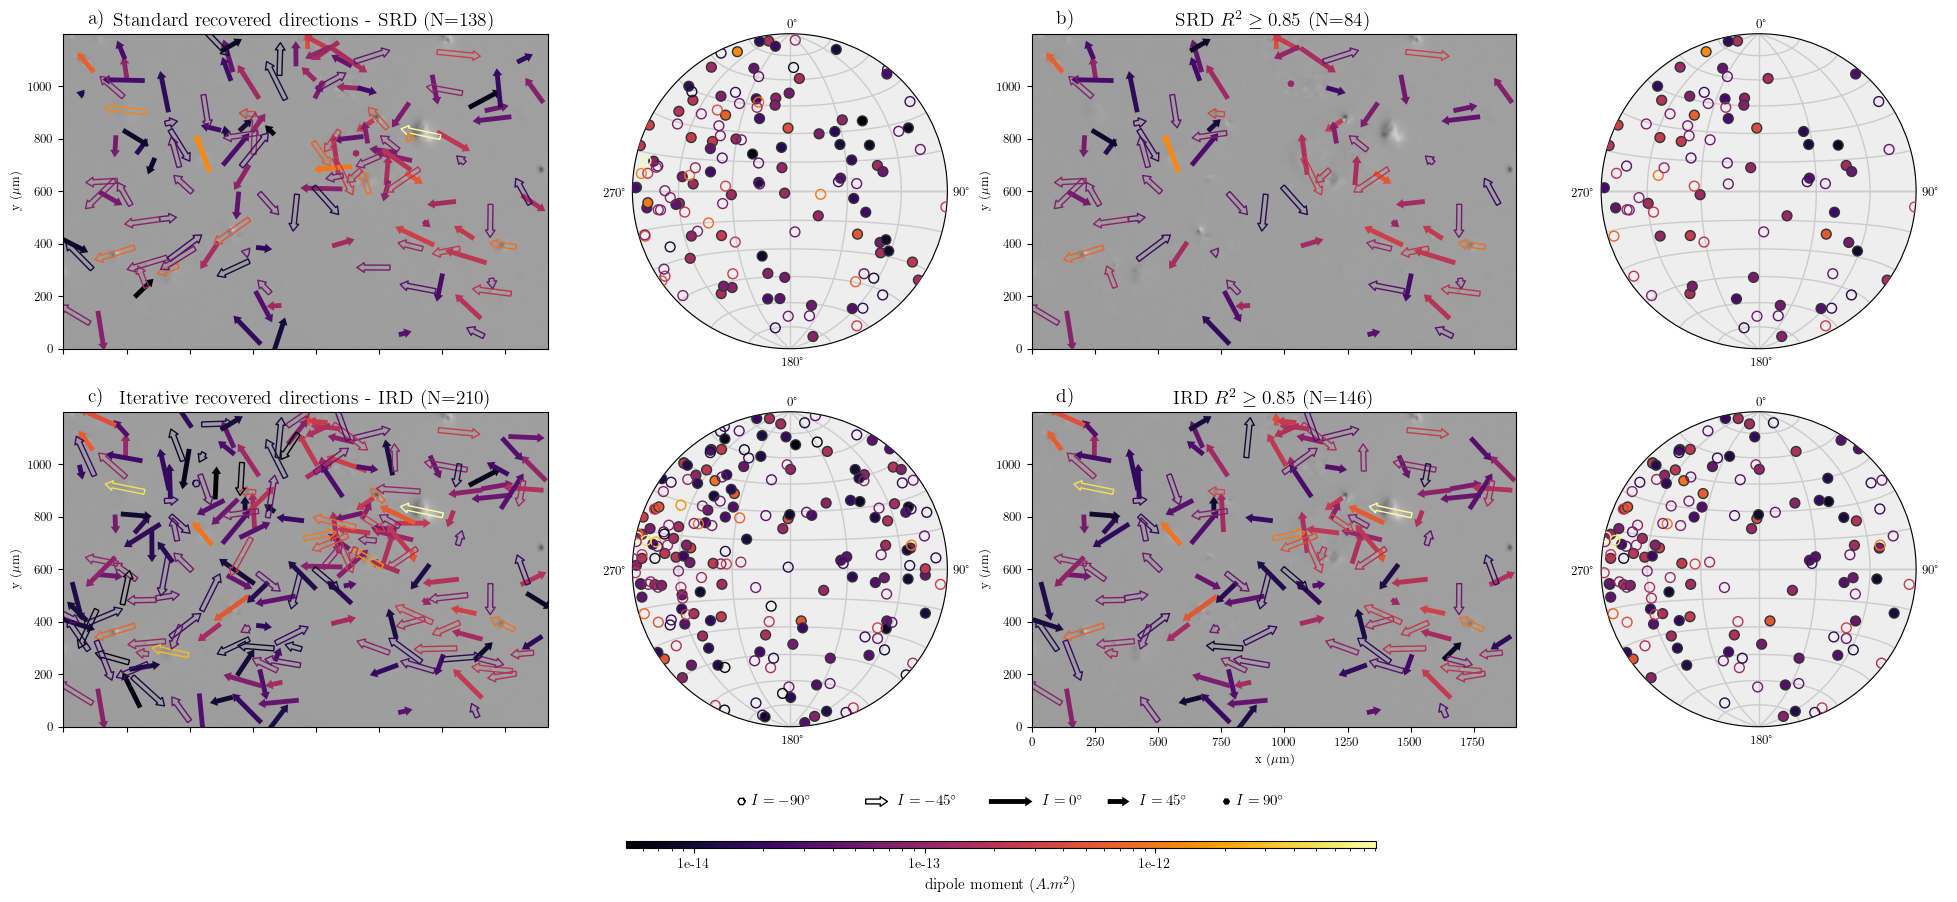

In [56]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

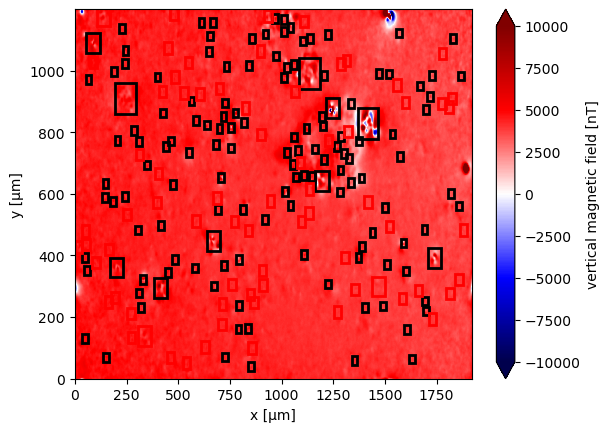

In [48]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [49]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([0.91729292, 0.96049727, 0.79668666, 0.98839093, 0.99197322,
       0.99940617, 0.87039631, 0.99680799, 0.91905897, 0.99324225,
       0.98588214, 0.82153322, 0.9047177 , 0.99063207, 0.92602511,
       0.97704183, 0.94610981, 0.93438105, 0.79958117, 0.99015465,
       0.98649988, 0.82637551, 0.99374688, 0.99348891, 0.99796163,
       0.88132251, 0.97475431, 0.95859851, 0.96111103, 0.99377801,
       0.98969289, 0.96700451, 0.96471196, 0.94054422, 0.60237692,
       0.96296378, 0.99350658, 0.97007735, 0.94946127, 0.96886945,
       0.99291863, 0.76690482, 0.96637695, 0.93052332, 0.99287538,
       0.4605247 , 0.9785928 , 0.99333774, 0.99383032, 0.96090693,
       0.9123775 , 0.98109651, 0.98205473, 0.99418045, 0.99757484,
       0.96804745, 0.96922804, 0.9703696 , 0.96969198, 0.93875884,
       0.24214248, 0.99025605, 0.58328563, 0.99589708, 0.57226865,
       0.82748613, 0.60690912, 0.75571772, 0.97687964, 0.97094681,
       0.88715769, 0.93047378, 0.68089489, 0.89745624, 0.53607

# Show the observed and predicted data

In [50]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

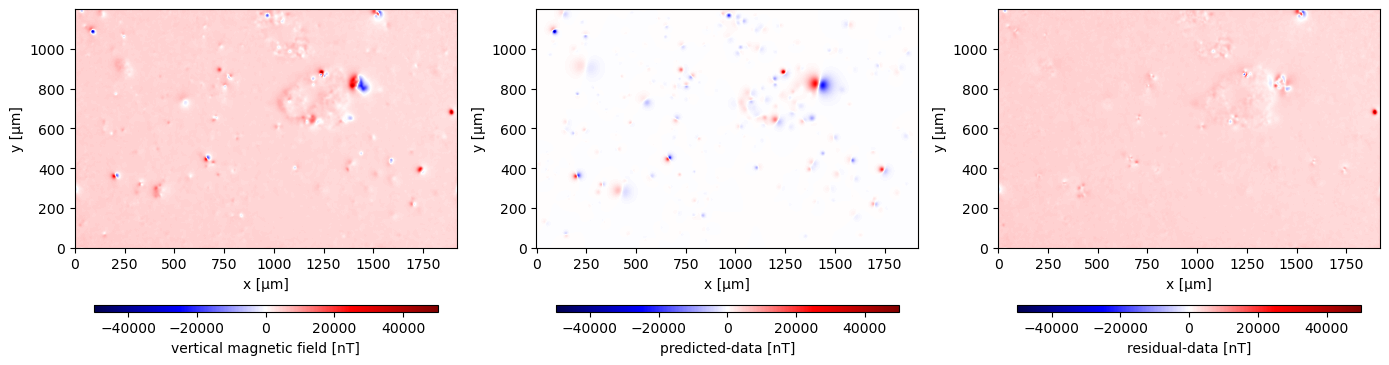

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +50000
    vmin = -50000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

In [52]:
i = 0
slice_start=0#-20
slice_end==15#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

NameError: name 'slice_end' is not defined